## Metaverse Transaction Data Analysis

### Script Goals
* Explore Meta Transaction Data and build a machine learning model to classify risk level categorically.
* Code such that other model types can easily be tested. 
* Contrast HalvingGridSearch and Bayesian Optimization with mean cross-validated scores. 

### Data Dictionary
https://www.kaggle.com/datasets/faizaniftikharjanjua/metaverse-financial-transactions-dataset

The dataset includes 78,600 records, each representing a metaverse transaction with the following attributes:

* **Timestamp:** Date and time of the transaction.
* **Hour of Day:** Hour part of the transaction timestamp.
* **Sending Address:** Blockchain address of the sender.
* **Receiving Address:** Blockchain address of the receiver.
* **Amount:** Transaction amount in a simulated currency.
* **Transaction Type:** Categorization of the transaction (e.g., transfer, sale, purchase, scam, phishing).
* **Location Region:** Simulated geographical region of the transaction.
* **IP Prefix:** Simulated IP address prefix for the transaction.
* **Login Frequency:** Frequency of login sessions by the user, varying by age group.
* **Session Duration:** Duration of activity sessions in minutes.
* **Purchase Pattern:** Behavioral pattern of purchases (e.g., focused, random, high-value).
* **Age Group:** Categorization of users into new, established, and veteran based on their activity history.
* **Risk Score:** Calculated risk score based on transaction characteristics and user behavior.
* **Anomaly:** Risk level assessment (e.g., high_risk, moderate_risk, low_risk)

In [1]:
### Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import skopt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from skopt.space import Real, Categorical, Integer
from lightgbm import LGBMClassifier

### Other Options
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [10,5]

# Multiple Outputs Per Code Block 
%config InteractiveShell.ast_node_interactivity = 'all'


In [3]:
# Read in Data
meta = pd.read_csv('C:/Your/File/Path') 

meta['timestamp'] = pd.to_datetime(meta['timestamp'])
meta = (meta.sort_values('timestamp') 
            .reset_index()
            .drop('index', axis = 1)
            )

meta.info()
meta.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78600 entries, 0 to 78599
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   timestamp          78600 non-null  datetime64[ns]
 1   hour_of_day        78600 non-null  int64         
 2   sending_address    78600 non-null  object        
 3   receiving_address  78600 non-null  object        
 4   amount             78600 non-null  float64       
 5   transaction_type   78600 non-null  object        
 6   location_region    78600 non-null  object        
 7   ip_prefix          78600 non-null  float64       
 8   login_frequency    78600 non-null  int64         
 9   session_duration   78600 non-null  int64         
 10  purchase_pattern   78600 non-null  object        
 11  age_group          78600 non-null  object        
 12  risk_score         78600 non-null  float64       
 13  anomaly            78600 non-null  object        
dtypes: dat

,timestamp,hour_of_day,sending_address,receiving_address,amount,transaction_type,location_region,ip_prefix,login_frequency,session_duration,purchase_pattern,age_group,risk_score,anomaly
0,2022-01-01 00:00:45,0,0x5e539dac6637b38aaf015861ec2da850f1ae8377,0x16c9903f99897fa292f3273513da8cf6525d0b06,592.024530,transfer,South America,10.00,6,84,high_value,veteran,49.6125,low_risk
1,2022-01-01 00:12:24,0,0xaaf2483f28bf10330253f83f9e016e1b900ad78b,0xa90b541bd2dfef162b82073318ace3fcc57340d9,755.500717,transfer,North America,172.16,3,70,focused,established,25.3125,low_risk
2,2022-01-01 00:14:54,0,0xccbf5a9926606c77db8391185066a8ee3bc0a2af,0x4f3070a2a31388c4897667752bbfac56d6426bb0,247.716361,transfer,Asia,192.00,5,54,focused,established,20.2500,low_risk
3,2022-01-01 00:27:12,0,0xffa670245089044b1e355508a7843692a25a5e52,0xc78a13e93a188c445584e724a855aeb94f972dd5,422.789709,purchase,North America,172.16,4,62,focused,established,35.4375,low_risk
4,2022-01-01 00:36:27,0,0xd92a3fafc71c2c3cde19665c9f46ec67638e33a1,0x55c98683de5bef9456cc9b82a87f0d8e942c7d6e,353.949174,sale,South America,172.16,7,94,high_value,veteran,70.8750,moderate_risk


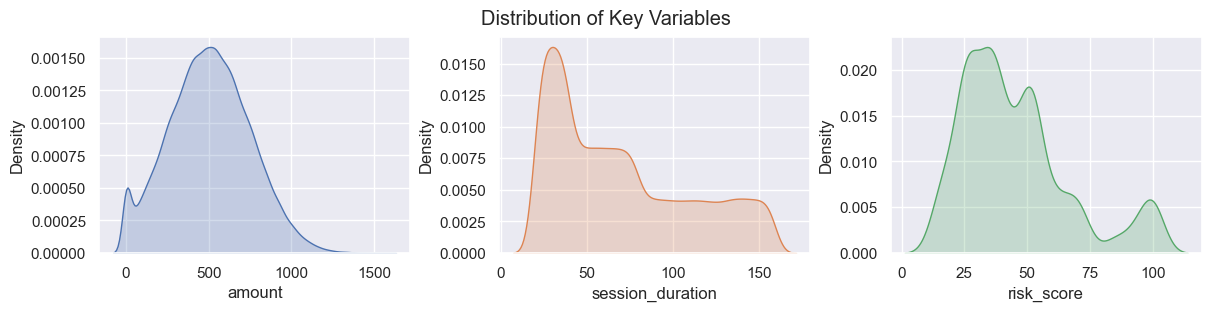

In [21]:
# Distribution of Key Variables

sns.set_theme()
fig, axs = plt.subplots(1, 3, figsize = (12,3), constrained_layout = True) 
sns.kdeplot(meta, x = 'amount', ax = axs[0], fill = True, color = '#4c72b0')
sns.kdeplot(meta, x = 'session_duration', ax = axs[1], fill = True, color = '#dd8452')
sns.kdeplot(meta, x = 'risk_score', ax = axs[2], bw_adjust = 2, fill = True, color = '#55a868')

plt.suptitle('Distribution of Key Variables'); 

In [3]:
### Session duration dist by transaction type
count = pd.DataFrame(meta.groupby('transaction_type')['transaction_type'].value_counts(ascending = True))
count['perc'] = (count['count'] / count['count'].sum() * 100 ).round(2)
# 	                count	perc
# transaction_type		
# phishing	        2546	3.24
# purchase	        24940	31.73
# sale	            25040	31.86
# scam	            3949	5.02
# transfer	        22125	28.15


Despite there being purchases and sales, there are no negative transaction types. 
* Will resolve this by multiplying purchases by -1 so sales and purchases are differentiated

In [4]:
# What are the categories within the categorical variables?
unique_cats = {col: meta[col].unique() for col in ['transaction_type', 'purchase_pattern', 'age_group', 'anomaly', 'location_region']}
unique_cats = pd.DataFrame({'variables': unique_cats.keys(),
                            'categories': unique_cats.values()})
print(unique_cats)

          variables                                         categories
0  transaction_type         [transfer, purchase, sale, scam, phishing]
1  purchase_pattern                      [high_value, focused, random]
2         age_group                        [veteran, established, new]
3           anomaly               [low_risk, moderate_risk, high_risk]
4   location_region  [South America, North America, Asia, Africa, E...


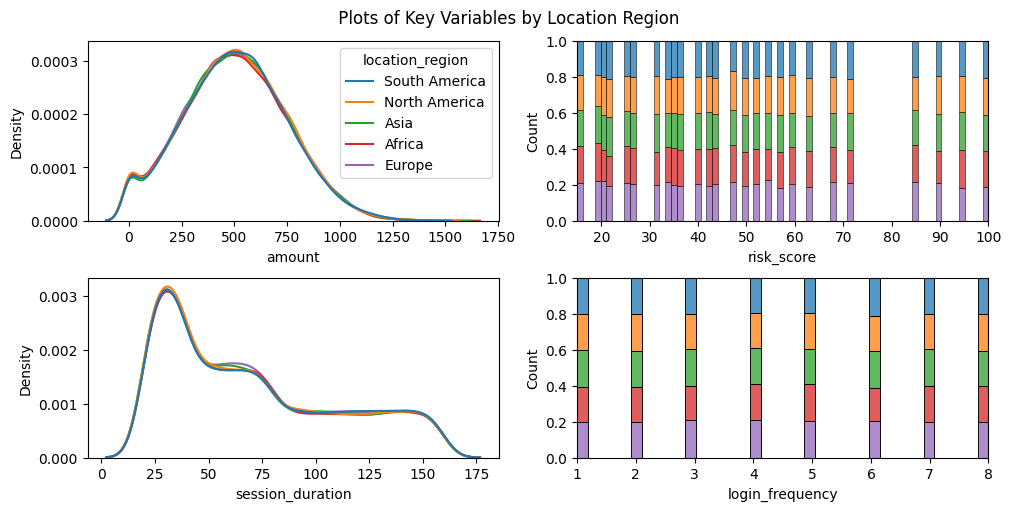

In [5]:
# Histograms based on location region
fig, axs = plt.subplots(2, 2, constrained_layout = True)
sns.kdeplot(meta, x = 'amount', hue = 'location_region', ax = axs[0,0])
sns.histplot(meta, x = 'risk_score', hue = 'location_region', multiple = 'fill', ax = axs[0,1], legend = False)
sns.kdeplot(meta, x = 'session_duration', hue = 'location_region', ax = axs[1,0], legend = False)
sns.histplot(meta, x = 'login_frequency', hue = 'location_region', multiple = 'fill', ax = axs[1,1], legend = False)
plt.suptitle(' Plots of Key Variables by Location Region'); 
# plt.tight_layout()

Region has almost no impact on the variables. Omitting Region from the analysis

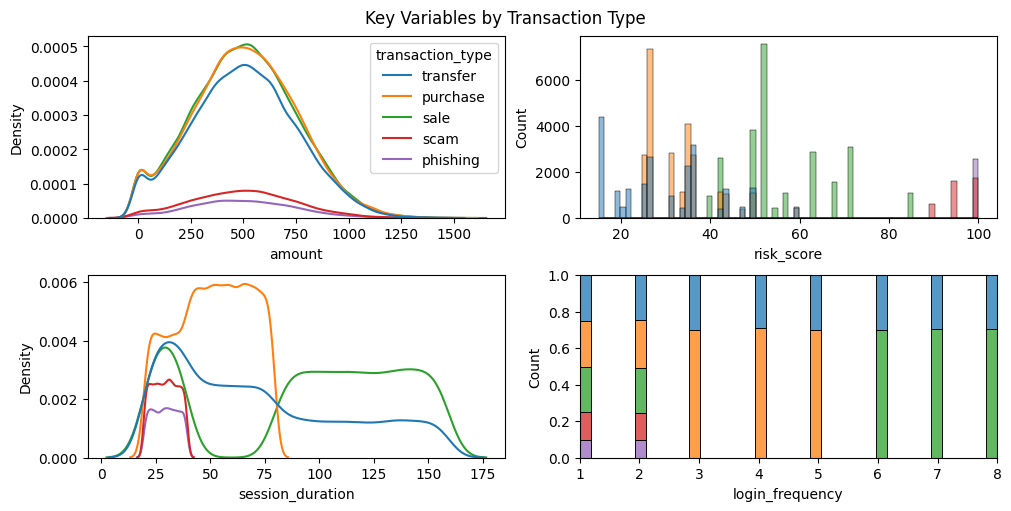

In [6]:
# Plots based on transaction type
fig, axs = plt.subplots(2, 2, constrained_layout = True)
sns.kdeplot(meta, x = 'amount', hue = 'transaction_type', ax = axs[0,0])
sns.histplot(meta, x = 'risk_score', hue = 'transaction_type', ax = axs[0,1], legend = False)
sns.kdeplot(meta, x = 'session_duration', hue = 'transaction_type', ax = axs[1,0], legend = False)
sns.histplot(meta, x = 'login_frequency', hue = 'transaction_type', multiple = 'fill', ax = axs[1,1], legend = False)
plt.suptitle('Key Variables by Transaction Type'); 

* Transaction type is notably different among the key variables. 
* Phishing and scam transaction types are reserved for high risk scores. 
* Simularly, Scam and Phishing solely exist when the session_duration is less than 50, and the login frequency is less that 3. 
* Also, The login frequency is unique for purchases and sales.

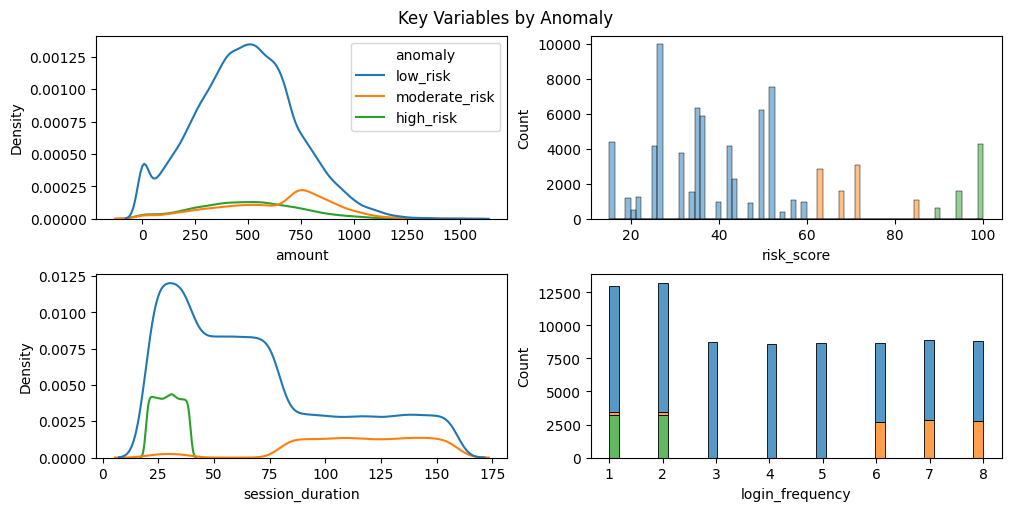

In [7]:
# Key Variables by Anomaly
fig, axs = plt.subplots(2,2, constrained_layout = True)
sns.kdeplot(meta, x = 'amount', hue = 'anomaly', ax = axs[0,0])
sns.histplot(meta, x = 'risk_score', hue = 'anomaly', ax = axs[0,1], legend = False)
sns.kdeplot(meta, x = 'session_duration', hue = 'anomaly', ax = axs[1,0], legend = False)
sns.histplot(meta, x = 'login_frequency', hue = 'anomaly', multiple = 'stack', ax = axs[1,1], legend = False) 
plt.suptitle('Key Variables by Anomaly')
plt.show(); 

* Anomaly is clearly partitioned by Risk Score
* Session duration is drastically less for high risk transactions
* Login Frequency is also drastically less for high risk transactions.

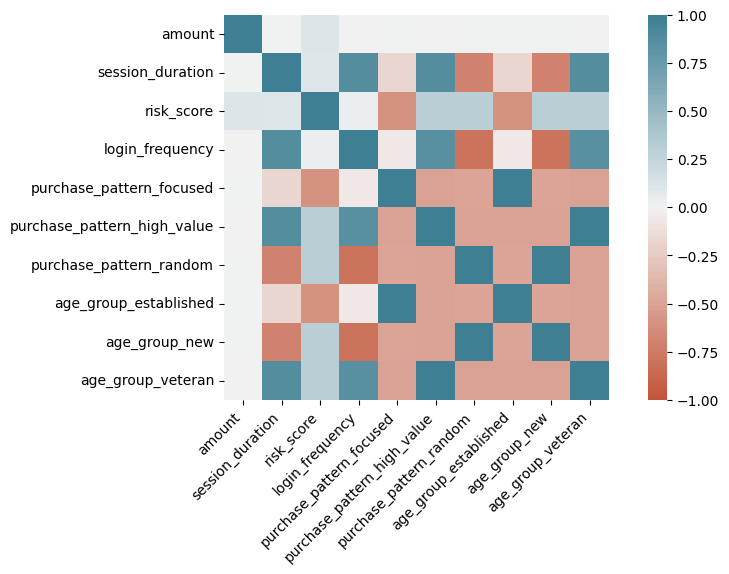

In [8]:
# Create indicator variables for purchase_pattern and age_group

# What is correlated with risk_score? (Important, since we will model on anomaly, which is derived from risk score)
indicator_vars = pd.get_dummies(meta[['purchase_pattern', 'age_group']], dtype = int)  # removing transaction type
indicator_vars.head()

corr = pd.concat([meta[['amount', 'session_duration', 'risk_score', 'login_frequency']], indicator_vars], axis = 1).corr()

# creating correlation heatmap
ax = sns.heatmap(
    corr, 
    vmin = -1, vmax = 1, center = 0,
    cmap = sns.diverging_palette(20, 220, n=200),
    square = True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right'
); 


* Surprisingly, all variables have near 0 correlation with the transaction ammount. 
* Strong negative relationships exist between the age group and purchase pattern indicators.
* A focused purchase pattern and the established age group have a negative correlation with the risk score. They are less likely to be fraudulant. 

In [9]:
### Preparing the following for day level stats
# 1. Sender and Receiver level variables: avg transaction amount, avg session duration, qty transactions
# 2. Hour level stats, Day of week level stats, Day level stats

# How many people are senders and recievers. Is there a side that is preferable to model for assessing if a transaction is high risk? 

sender_stats = (meta.groupby('sending_address')
                .agg({'sending_address': 'count'})
                .rename(columns = {'sending_address': 'sender_transaction_count'})
                )

receiver_stats = (meta.groupby('receiving_address')
                  .agg({'receiving_address': 'count'})
                  .rename(columns = {'receiving_address': 'receiver_transaction_count'})
                  )

# hour_level_stats = (meta.filter(['timestamp', 'hour_of_day', 'amount', 'session_duration', 'login_frequency'])
#                    .groupby('hour_of_day')
#                    .agg({'amount': 'mean',
#                          'session_duration': 'mean',
#                          'login_frequency': 'mean'}) 
#                    .rename(
#                         columns = {'amount': 'hour_avg_amount',
#                                    'session_duration': 'hour_avg_session_duration',
#                                    'login_frequency': 'hour_avg_login_frequency'})
#                    ) 

# day_of_week_stats = (meta.assign(day_of_week = lambda x: x['timestamp'].dt.strftime('%a'))
#                          .filter(['timestamp', 'day_of_week', 'amount', 'session_duration', 'login_frequency'])
#                          .groupby('day_of_week')
#                          .agg({'amount': 'mean',
#                                'session_duration': 'mean',
#                                'login_frequency': 'mean'})
#                          .rename(
#                              columns = {'amount': 'day_avg_amount',
#                                         'session_duration': 'day_avg_session_duration',
#                                         'login_frequency': 'day_avg_login_frequency'
#                              })
#                          )

# # Is there variation over time by day? 
# day_stats = (meta.assign(day = lambda x: x['timestamp'].dt.strftime('%d'))
#                          .filter(['timestamp', 'day', 'amount', 'session_duration', 'login_frequency'])
#                          .groupby('day')
#                          .agg({'amount': 'mean',
#                                'session_duration': 'mean',
#                                'login_frequency': 'mean'})
#                          .rename(
#                              columns = {'amount': 'day_avg_amount',
#                                         'session_duration': 'day_avg_session_duration',
#                                         'login_frequency': 'day_avg_login_frequency'
#                              })
#                          )

# print(sender_stats.head())
# print(receiver_stats.describe())
# print(hour_level_stats.describe())
# print(day_of_week_stats.describe())
# print(day_stats.describe())
# Join sender stats by sending address, reciever stats by receiving stats

* Of the features created at the sender and receiver level, only transaction count has a large amount of variation. Limited the dataframe to that variable with joining
* After Reviewing the Hour and Day of Week, and Day level stats, there is a shockingly small amount of standard deviation. That, paired with the transaction amount being carried out to 10 digits, leads me to believe the data has been simulated. Will not include stats at this level in the modeling dataframe (Have commented the code out)

Excluded the following from the model to prevent it being overfit and performing poorly on validation datasets:
* 'timestamp', 'sending_address', 'receiving_address', 'transaction_type', 'location_region', 'ip_prefix', 'risk_score', 'purchase_pattern', 'age_group'

In [10]:
# Combining Indicator Variables, Sender / Reciever transaction count, and original variables. Omitting variables used to create the classification categories (transaction_type (scam, phishing categories), and risk_score)

meta_model_df = (meta.merge(sender_stats, how = 'left', on = 'sending_address')
                 .merge(receiver_stats, how = 'left', on = 'receiving_address')
                 .merge(indicator_vars, how = 'left', right_index = True, left_index = True)
                 # Reprogram anomaly to be binary to focus on detecting high risk accounts
                 # # # High Risk == 1, Low to moderate Risk == 0 # # #
                 .assign(anomaly_binary = lambda x: x['anomaly'].replace({'low_risk': 0, 'moderate_risk': 0, 'high_risk': 1}),
                         # Make purchases negative transactions to differentiate sales and purchases since transaction_type is being removed
                         amount = lambda x: x['amount'].where(x['transaction_type'] != 'purchase', -x['amount'])
                         )
                 .drop(['timestamp', 'sending_address', 'receiving_address', 'transaction_type', 
                        'location_region', 'ip_prefix', 'risk_score', 'purchase_pattern', 'age_group'], axis = 1)
                 # day of year or num days?
                 ) 

# Training Set and validation set
df_x = meta_model_df.drop(columns = ['anomaly', 'anomaly_binary'])
df_y = meta_model_df['anomaly'] # as category?
  
### Train / Test split. Stratify by underrepresented class
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.25, stratify = df_y, random_state = 152)

# Recombine Training sets to downsample
training_sets = pd.concat([x_train, y_train], axis = 1)
min_class_size = training_sets['anomaly'].value_counts().min() # underepresented class (high risk) count

# Downsample training set to resolve problems with unbalanced data
downsampled_train = (training_sets.groupby('anomaly', group_keys = False)
                     .apply(lambda x: 
                            x.sample(n = min_class_size, random_state = 44, replace = True))
                     # Reshuffle 
                     .sample(frac = 1, random_state = 42))

# Override training sets with downsampled versions
x_train = downsampled_train.drop(columns = 'anomaly')
y_train = downsampled_train['anomaly']


In [11]:
# Try HalvingGridSearch with Light GBM
classifier = LGBMClassifier()
param_grid = {'objective': ['multiclass'], # ['multiclass']
              'learning_rate': [.05, .1, .2, .25, .4], 
              'max_depth': [4, 5, 6, 7], 
              'num_leaves': [2**4, 2**5, 2**6, 2**7, 2**8], 
              'verbosity': [-1],
              'force_col_wise': [True]
              }

# HalvingGridSearchCV
mini_grid_search = (HalvingGridSearchCV(classifier, param_grid, cv = 2, random_state = 41, n_jobs = -1) 
                    .fit(x_train, y_train)); 

print(f"Best parameters for {classifier}:\n{mini_grid_search.best_params_}")
print(f"Best score: {mini_grid_search.best_score_:.4f}\n") # .9047 binary, .9007 multiclass (lower high-risk accuracy though), without indicator variables

# Thoughts: HalvingGridSearchCV is difficult to use with some Light GBM Params. It requires an explicit grid search, but is resource efficient. It is a good method to select parameters, and it conveniently allows cross validation.


Best parameters for LGBMClassifier():
{'force_col_wise': True, 'learning_rate': 0.05, 'max_depth': 4, 'num_leaves': 32, 'objective': 'multiclass', 'verbosity': -1}
Best score: 0.9007



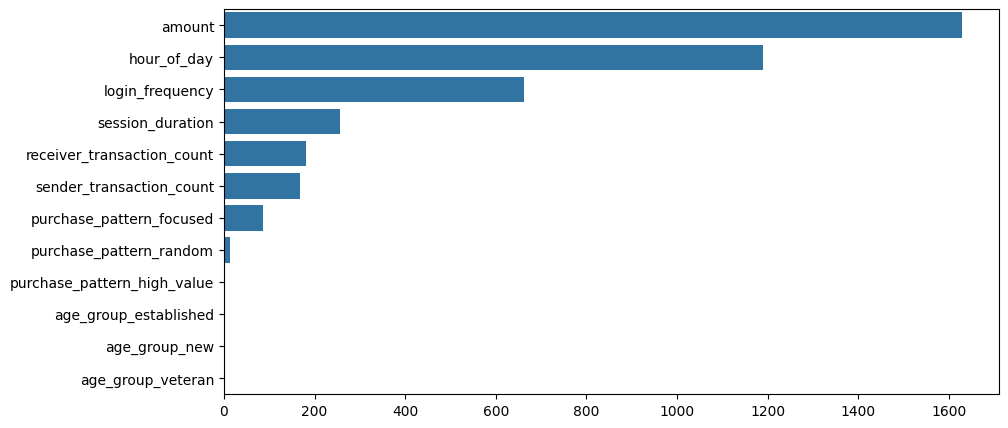

In [12]:
# Predictions on highest performing light gbm model:
y_pred = mini_grid_search.best_estimator_.predict(x_test) 

# Feature Importance Plot
opt_model = LGBMClassifier(**mini_grid_search.best_params_).fit(x_test, y_test)

feature_importance = opt_model.feature_importances_
feature_names = x_test.columns.to_list()

importances_df = pd.DataFrame({"feature_names" : feature_names, 
                              "importances" : feature_importance})

feature_importance_plot = sns.barplot(data = importances_df,
                                      x = feature_importance,
                                      y = feature_names,
                                      order = importances_df.sort_values('importances', ascending = False).feature_names)

feature_importance_plot; 

               precision    recall  f1-score   support

    high_risk       0.33      0.99      0.50      1624
     low_risk       1.00      0.75      0.86     15873
moderate_risk       0.69      0.96      0.81      2153

     accuracy                           0.79     19650
    macro avg       0.68      0.90      0.72     19650
 weighted avg       0.91      0.79      0.82     19650



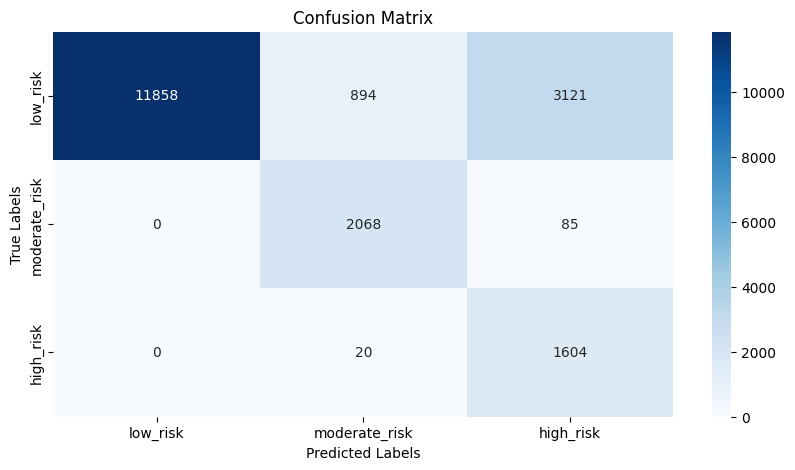

In [13]:
# Report and Confusion Matrix
print(classification_report(y_test, y_pred))
class_labels = ['low_risk', 'moderate_risk', 'high_risk']
cm = confusion_matrix(y_test, y_pred, labels = class_labels) # Are these labels in the right order? 

sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels = class_labels, yticklabels = class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show(); 


In [14]:
### Trying BayesSearchCV 

# Parameter Space
param_space = {
   'learning_rate': Real(0.01, 1, prior = 'uniform'),
   'num_leaves': Integer(10, 50),
   'max_depth': Integer(3, 10),
   'boosting_type': Categorical(['gbdt', 'dart']),
   'feature_fraction': Real(0.1, 1, prior = 'uniform'),
   'subsample': Real(0.1, 1, prior = 'uniform')
}

# Bayesian Optimization with Cross Validation
light_gbm_bayes_cv = skopt.BayesSearchCV(
    estimator = lgb.LGBMClassifier(),
    search_spaces = param_space,
    scoring = 'accuracy', 
    cv = 5,
    n_iter = 50, 
    n_jobs = -1,
    return_train_score = True,
    random_state = 42 
).fit(x_train, y_train); 

# ~ for binary classification 2 minutes to run, greatly dependent on n_iter (number of parameter settings sampled). For multiclass 6.5 minutes

[LightGBM] [Warning] feature_fraction is set=0.894983749642776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.894983749642776
[LightGBM] [Warning] feature_fraction is set=0.894983749642776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.894983749642776
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 469
[LightGBM] [Info] Number of data points in the train set: 14613, number of used features: 12
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

Best Parameters Found: {'boosting_type': 'dart', 'feature_fraction': 0.894983749642776, 'learning_rate': 0.3103760087853332, 'max_depth': 10, 'num_leaves': 45, 'subsample': 0.15608164675966435}
Best Score: 0.9070015874008284
[LightGBM] [Warning] feature_fraction is set=0.894983749642776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.894983749642776
[LightGBM] [Warning] feature_fraction is set=0.894983749642776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.894983749642776
[LightGBM] [Warning] feature_fraction is set=0.894983749642776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.894983749642776
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 469
[LightGBM] [Info] Number of data points in the train set: 19

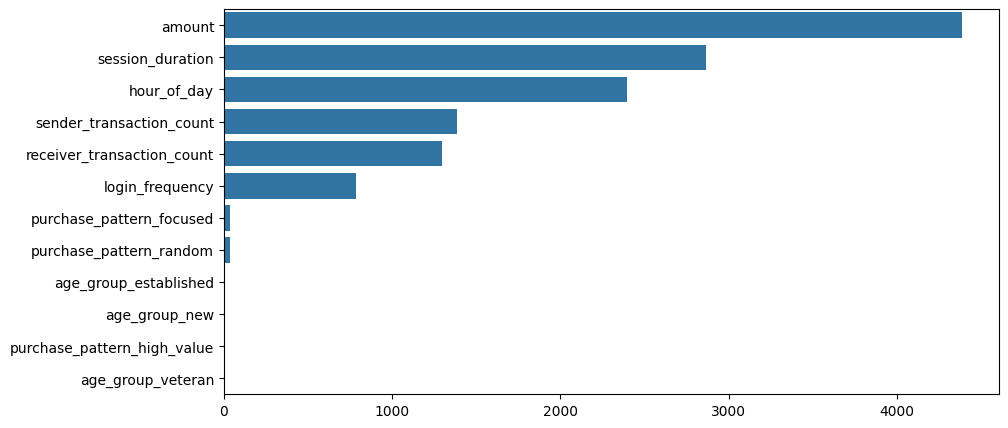

In [15]:
# Best parameters found
print("Best Parameters Found:", dict(light_gbm_bayes_cv.best_params_))
# {'boosting_type': 'dart', 
#  'feature_fraction': 1.0, 
#  'learning_rate': 0.3802263207399061, 
#  'max_depth': 3, 
#  'num_leaves': 10, 
#  'subsample': 0.31848339045102975}

# Best score achieved
print("Best Score:", light_gbm_bayes_cv.best_score_) # .905, .907 for multiclass

# Model Validated using optimal parameters
y_pred = light_gbm_bayes_cv.predict(x_test); # can use predict_proba to give probability ranked scoring of observation

# Feature Importance Plot
opt_model = LGBMClassifier(**light_gbm_bayes_cv.best_params_).fit(x_test, y_test); 

feature_importance = opt_model.feature_importances_
feature_names = x_test.columns.to_list()

importances_df = pd.DataFrame({"feature_names" : feature_names, 
                              "importances" : feature_importance})

feature_importance_plot = sns.barplot(data = importances_df,
                                      x = feature_importance,
                                      y = feature_names,
                                      order = importances_df.sort_values('importances', ascending = False).feature_names)

feature_importance_plot; 

               precision    recall  f1-score   support

    high_risk       0.33      0.94      0.49      1624
     low_risk       1.00      0.75      0.86     15873
moderate_risk       0.69      0.97      0.80      2153

     accuracy                           0.79     19650
    macro avg       0.67      0.89      0.72     19650
 weighted avg       0.91      0.79      0.82     19650



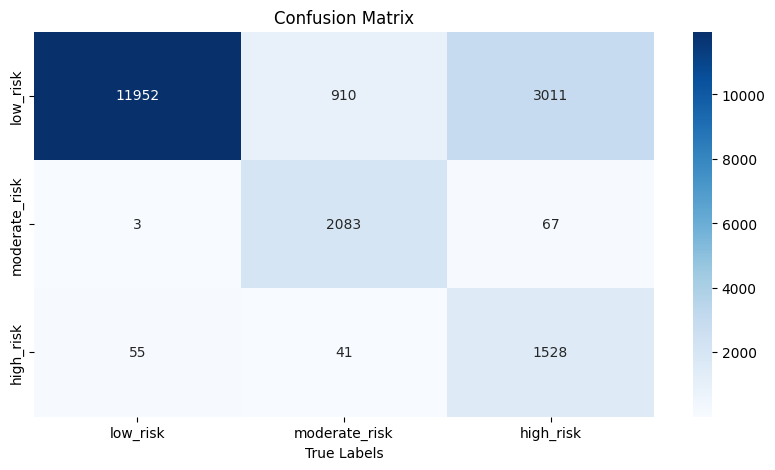

In [19]:
# Report and Confusion Matrix
print(classification_report(y_test, y_pred))
class_labels = ['low_risk', 'moderate_risk', 'high_risk']
cm = confusion_matrix(y_test, y_pred, labels = class_labels);  # Are these labels in the right order? 

sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels = class_labels, yticklabels = class_labels); 
plt.xlabel('Predicted Labels'); 
plt.xlabel('True Labels'); 
plt.title('Confusion Matrix'); 
plt.show(); 

# binary_preds = pd.Series(y_pred).reset_index().drop(columns = 'index')
# probs = pd.Series(light_gbm_bayes_cv.predict_proba(x_test)[:,1]).reset_index().drop(columns = 'index'); 
# y_test_result = pd.Series(y_test).reset_index().drop(columns = 'index')

## Test set probability distribution 
# results_df = pd.concat([probs, binary_preds, y_test_result], 
#                        axis = 1, 
#                        keys = ['probs', 'binary_preds', 'y_test_result'])

# results_df.columns = results_df.columns.get_level_values(0)
# results_df.head()

### If using binary classification
# fig, axs = plt.subplots(1, 2, constrained_layout = True)
# sns.histplot(results_df, x = 'probs', 
#              bins = 50, kde = True, ax = axs[0]) # Probability of being a high risk transaction
# # Create his removing the probabilities less than .1
# sns.histplot(results_df[results_df['probs'] > .1], x = 'probs', 
#              bins = 50, kde = True, ax = axs[1], hue = 'y_test_result')


# Further Analysis Might Include
* Investigating the differences in features for the high risk versus the low-moderate risk classes
* Testing other model types and optimizing parameters for each model.
* Creating ensemble model of optimized models to improve accuracy further.